In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RS = 20040304
np.random.seed(RS)

In [2]:
df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

labels = {
    0: 'T-shirt/top',
    1: 'Trousers',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

In [3]:
def normalize(df, exclude_col):
    df_n = df.drop(columns=exclude_col)
    df_n = df_n / 255.
    df_n[exclude_col] = df[exclude_col]
    return df_n

df_train = normalize(df_train, 'label')
df_test = normalize(df_test, 'label')

df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3


In [4]:
df_train_px = df_train.drop(columns='label')
df_test_px = df_test.drop(columns='label')
df_all_px = df_all.drop(columns='label')

df_all_px.head()


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


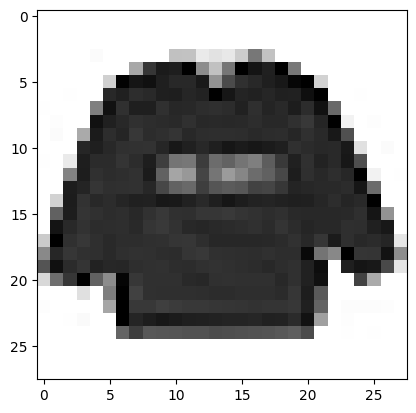

In [5]:
def plot_image(df, index, x = 28, y = 28):
    img = df.iloc[index, :].to_numpy().reshape(x, y)
    plt.imshow(img, cmap='gray_r', vmin=0, vmax=1)

plot_image(df_all_px, 0)

## Dimensionality reduction

### PCA

The images contain a lot of redundant data - on the corners they are white, and in the middle they are mostly black. I have therefore decided, that PCA would be a good first step in the dimensionality reduction process, since a lot of the principal components will be insignificant.

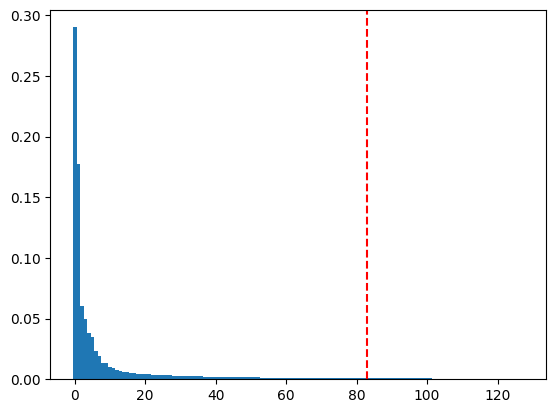

In [6]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RS)
pca.fit(df_all_px)
scree_data = pca.explained_variance_ratio_

# 90% of the variance should remain
thresh = 0.9

sum = 0
idx = 0
for idx, el in enumerate(scree_data):
    sum += el
    if sum > thresh:
        break

scree_len = 128
plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5)
# plt.yscale('log')
plt.bar(range(scree_len), scree_data[:scree_len], width=1)
plt.show()

As expected, the scree plot (with the x axis clipped to 128 from the original 784, to improve readability) shows that the vast majority of principal components are insignificant. 

The red line on the scree plot represents the point to which I have decided to reduce the dimensionality, so that 90% of the variance remains. 

An interesting approach to visualising the components is plotting them as images (0 - white, 1 - black), to see the patterns that they represent. I found the component with index 1 to be particularly entertaining, since it looks like a pair of trousers. Components with higher indices are much more messy - component 32 only barely resembles the silhouette of a clothing item, whereas component 512 is an almost complete mess.

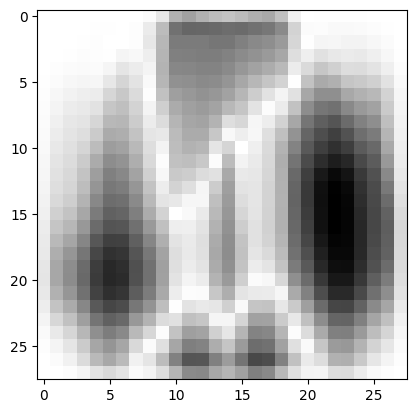

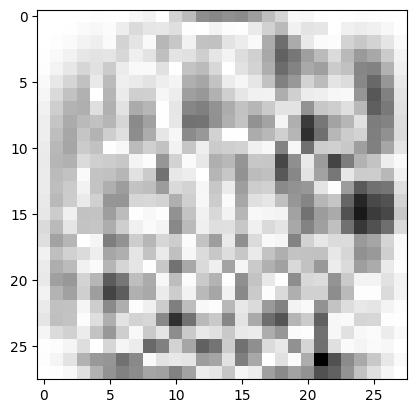

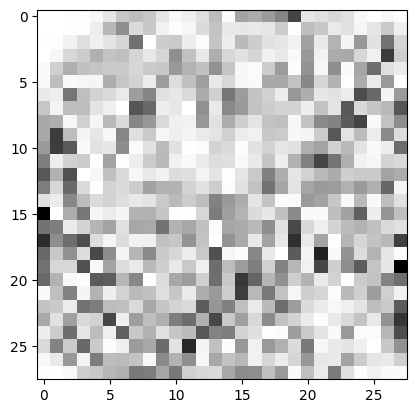

In [7]:
def plot_component(component_idx):
    def component_normalize(arr):
        return arr / np.max(arr)

    plot_image(pd.DataFrame(component_normalize(np.abs(pca.components_[component_idx])).reshape(1, -1)), 0)
    plt.show()

plot_component(1)
plot_component(32)
plot_component(512)

In [8]:
# Perform the reduction
n_components = idx + 1
pca = PCA(n_components=n_components, random_state=RS)
reduced_pca = pca.fit_transform(df_all_px)
print(f"Dimensionality reduced to: {n_components}")

Dimensionality reduced to: 84


### t-SNE

Next, to be able to visualise the dataset, I decided to apply some more advanced algorithms to the PCA-reduced dataset. The first of them I tried was t-SNE. It turned out, however, to be frustratingly slow, so in the experimental phase I used a random selection of 20% of the data.

In [9]:
# from sklearn.manifold import TSNE

# df_pick_ratio = 0.1
# # df_pick_ratio = 1.0
# df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

# tsne = TSNE(n_components=2, random_state=RS)
# reduced_tsne = tsne.fit_transform(reduced_pca[df_mask])

In [10]:
from matplotlib.colors import ListedColormap

def plot_2d(reduced, df_mask):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown']
    cmap = ListedColormap(colors)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=labels[i]) for i in labels]
    
    # Add legend
    plt.legend(handles=legend_handles, title='Categories', loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0.)

    plt.scatter(reduced[:, 0], reduced[:, 1], c=df_all['label'][df_mask], cmap=cmap, s=1, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

# plot_2d(reduced_tsne, df_mask)

t-SNE managed to separate some of the categories, but most of them remained jumbled together. Trousers and bags are very easy to distinguish, each in their own, well separated cluster. Sandals, ankle boots and sneakers are in three corners of one cluster. T-shirts/tops and dresses are somehow separated, but dresses are spread around T-shirts over two clusters. Pullovers, coats and shirts are a complete mess. 

With hopes of achieving better separation, I have decided to try out another algorithm, which I heard is faster and more efficient than t-SNE - UMAP.

### UMAP
UMAP did indeed prove to be much faster, which made experimenting with algorithm parameter values much easier. I have settled on `n_neighbors = 5` and `min_dist = 0.05`, since they seemed to provide a good balance, making the clusters concentrated but at the same time not splitting them into too many smaller subclusters.

In [11]:
from umap import UMAP

df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

umap = UMAP(n_components=2, random_state=RS, n_neighbors=5, min_dist=0.05)
reduced_umap = umap.fit_transform(reduced_pca[df_mask])

/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/frun/agh/sem5/fods/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


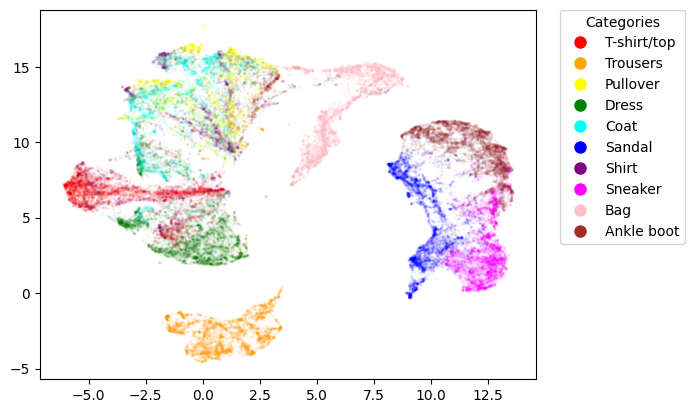

In [12]:
plot_2d(reduced_umap, df_mask)

The results produced by UMAP don't seem to be much better than those produced by t-SNE. It did however manage to make the clusters denser, and distinguished T-shirts/tops from dresses somewhat better.

I therefore conclude, that using those algorithms the dataset cannot be represented in 2d as well as e.g. the MNIST handwritten digit dataset. Clustering therefore needs to be performed in a higher dimensional space.

For visualisation purposes I will be using the t-SNE result - I find the sparser plot to be a bit more readable.

## Clustering

### KMeans


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix

df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

kmeans = KMeans(n_clusters=10, random_state=RS)
kmeans.fit(reduced_pca)

print(adjusted_rand_score(df_all['label'], kmeans.labels_))

0.38561659414169536


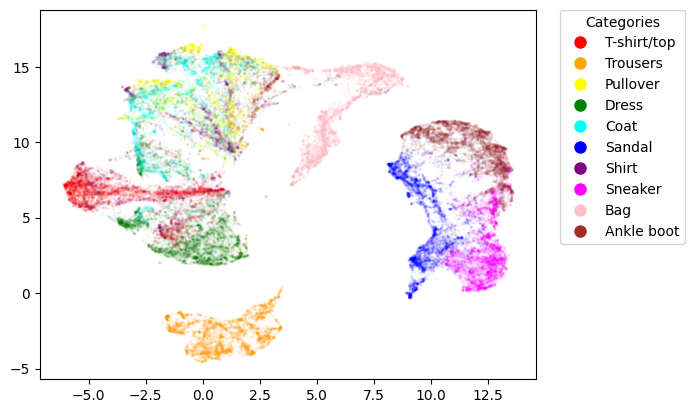

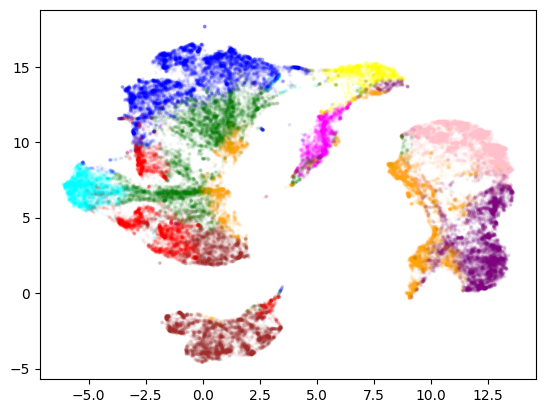

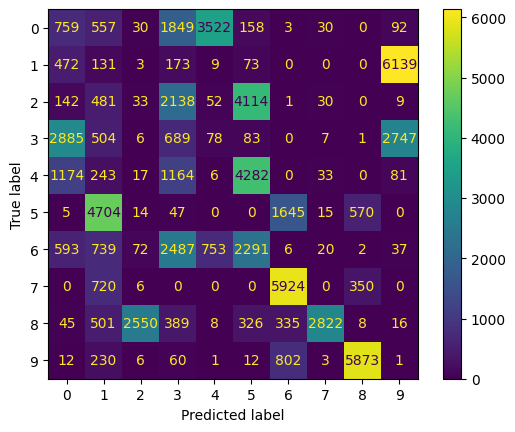

In [19]:
def plot_clusters(points, cluster_labels, df_mask):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown']
    cmap = ListedColormap(colors)

    plt.scatter(points[:, 0], points[:, 1], c=cluster_labels[df_mask], cmap=cmap, s=3, alpha=0.04/(np.sum(df_mask)/len(df_mask)))
    plt.show()

plot_2d(reduced_umap, df_mask)
plot_clusters(reduced_umap, kmeans.labels_, df_mask)

m = contingency_matrix(df_all['label'], kmeans.labels_)
disp = ConfusionMatrixDisplay(m)
disp.plot()
plt.show()

In [20]:
umap_cluster = UMAP(n_components=16, n_neighbors=5, min_dist=0.1)
reduced_umap_cluster = umap_cluster.fit_transform(reduced_pca)

In [40]:
from sklearn.cluster import DBSCAN

df_pick_ratio = 1.0
df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

dbscan = DBSCAN(eps=1.3, min_samples=1950)
dbscan.fit(reduced_umap_cluster)

print(np.unique(dbscan.labels_))

print(adjusted_rand_score(df_all['label'], dbscan.labels_))
print(f"Noise ratio: {(dbscan.labels_ == -1).sum() / len(dbscan.labels_)}")

[-1  0  1  2  3  4  5  6  7  8  9]
0.4855044126500402
Noise ratio: 0.0661


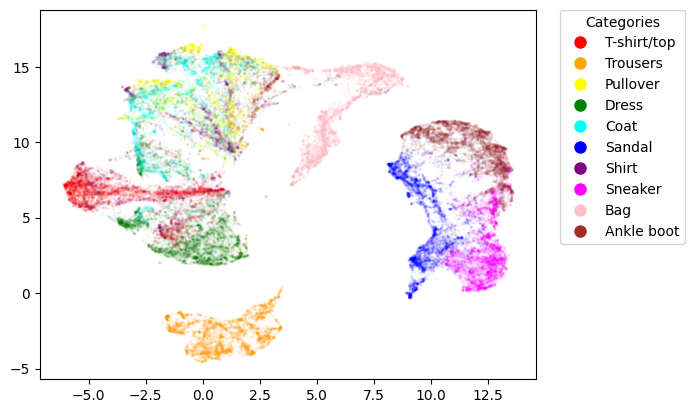

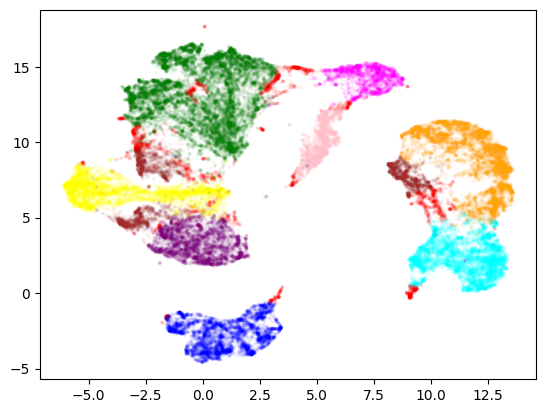

In [41]:
plot_2d(reduced_umap, df_mask)
plot_clusters(reduced_umap[df_mask], dbscan.labels_, df_mask)

In [47]:
from sklearn.cluster import SpectralClustering

df_pick_ratio = 0.1
df_mask = np.random.choice([True, False], size=len(reduced_pca), p=[df_pick_ratio, 1 - df_pick_ratio])

sc = SpectralClustering(n_clusters=10, random_state=RS, n_neighbors=50)
sc.fit(reduced_umap_cluster[df_mask])

print(adjusted_rand_score(df_all['label'][df_mask], sc.labels_))

0.5017143220110255


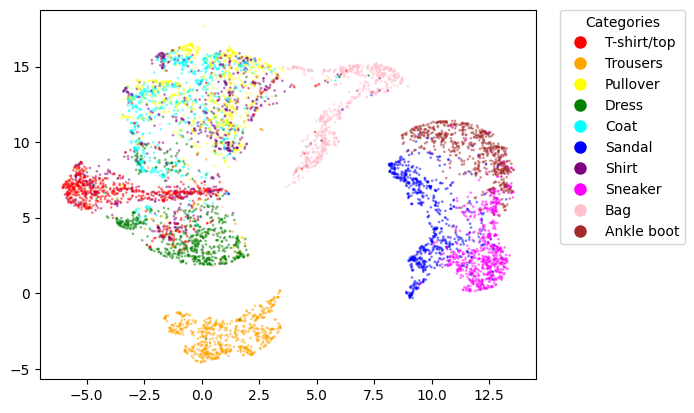

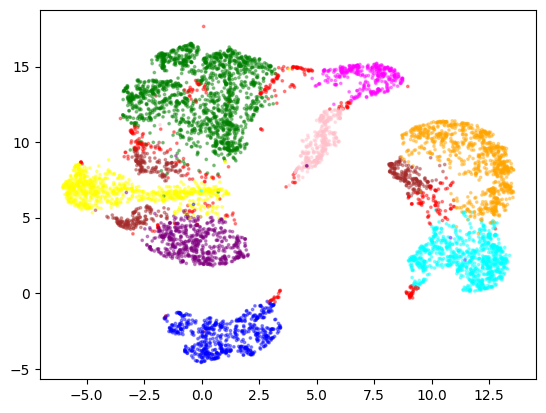

In [48]:
plot_2d(reduced_umap[df_mask], df_mask)
plot_clusters(reduced_umap[df_mask], dbscan.labels_, df_mask)

In [ ]:

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], reduced_tsne[:, 2], c=df_all['label'][:2000], cmap='Accent')
# ax.view_init(elev=45, azim=50)

# plt.show()

# # Parameters for the grid
# rows, cols = 3, 3  # Create a 3x3 grid of plots
# elevations = [-30, 0, 30]  # Different elevations for rows
# azimuths = [-60, 0, 60]    # Different azimuths for columns

# fig, axes = plt.subplots(rows, cols, subplot_kw={'projection': '3d'}, figsize=(15, 15))

# # Loop through the grid and plot
# for i in range(rows):
#     for j in range(cols):
#         ax = axes[i, j]
#         elev = elevations[i]
#         azim = azimuths[j]
        
#         # Scatter plot
#         sc = ax.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], reduced_tsne[:, 2], 
#                         c=df_all['label'][:2000], cmap='Accent', s=10)
        
#         # Set different rotations
#         ax.view_init(elev=elev, azim=azim)
#         ax.set_title(f"Elev: {elev}, Azim: {azim}")

# # Adjust layout
# plt.tight_layout()
# plt.show()